# Kaggle Titanic competition

This notebook covers the following areas:

- Exploration
- Data cleaning & feature engineering
- Modelling:
    - Random forest
    - Ensemble via majority voting: Logistic Regression, Random Forest, Gradient Boost
- Learning curve (accuracy vs sample size)
- Validation curve (accuracy vs complexity)
- Feature selection using random forest importance
- Hyperparameters tuning via random grid search
- ROC

In [57]:
import warnings
import pandas as pd
import numpy as np
from time import time
from scipy.stats import randint as sp_randint
from scipy import interp

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score, LeaveOneOut, train_test_split, \
                                    GridSearchCV, learning_curve, validation_curve, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier, \
                             ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

# xg boost
import xgboost as xgb

# Configure visualisations
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('whitegrid')
pylab.rcParams[ 'figure.figsize' ] = 15, 6

# Load

In [2]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')
train_raw['train_test'] = 'train'
test_raw['train_test'] = 'test'

train_test = train_raw.append(test_raw, ignore_index=True)
train_test.columns = [x.lower() for x in train_test.columns.tolist()]

In [3]:
train_test.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,train_test
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train


# Exploration

In [4]:
train_test.describe()

,age,fare,parch,passengerid,pclass,sibsp,survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


### Pairwise correlation

Does not look like there are strong linear correlations between variables

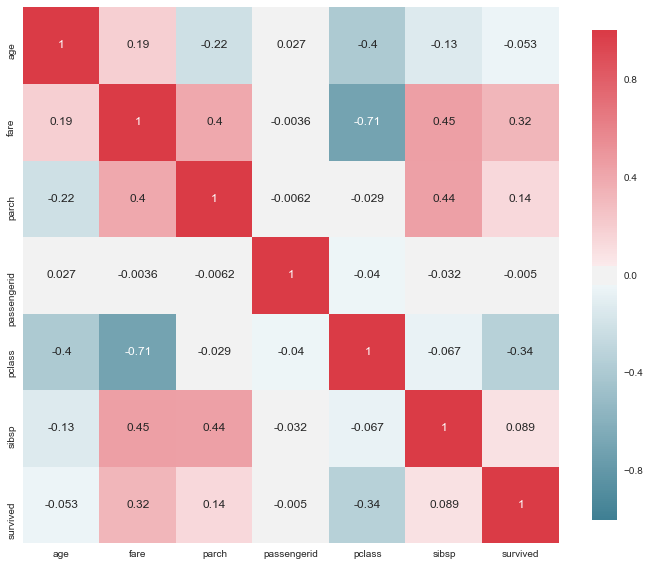

In [8]:
def plot_correlation_map( df , method):
    corr = df.corr(method=method)
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

# methods = ['pearson', 'spearman', 'kendall']
# pearson: linear correlation
# spearman, kendall: rank correlation
plot_correlation_map(df=train_test, method='spearman')

### Looking at categorical variables

Sex='male' and PClass = 3 were less likely to survive

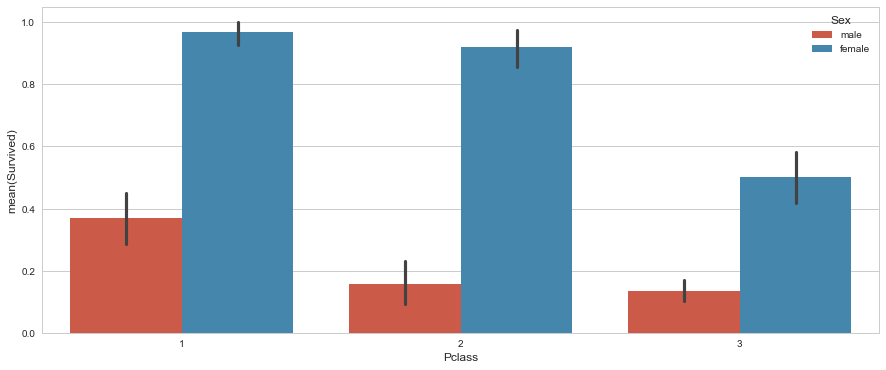

In [9]:
_ = sns.barplot(x='Pclass', y="Survived", hue="Sex", data=train_raw)

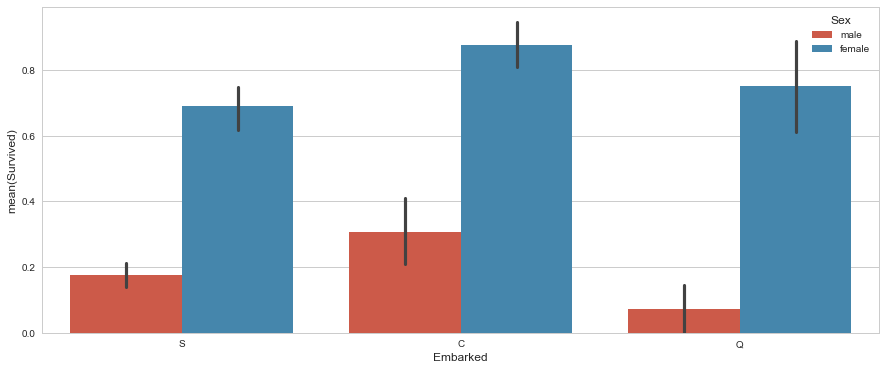

In [10]:
_ = sns.barplot(x='Embarked', y="Survived", hue="Sex", data=train_raw)

### Looking at numerical variables

Male adults and people with low fare tickets seemed to be less likely to survive

In [14]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
#     facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

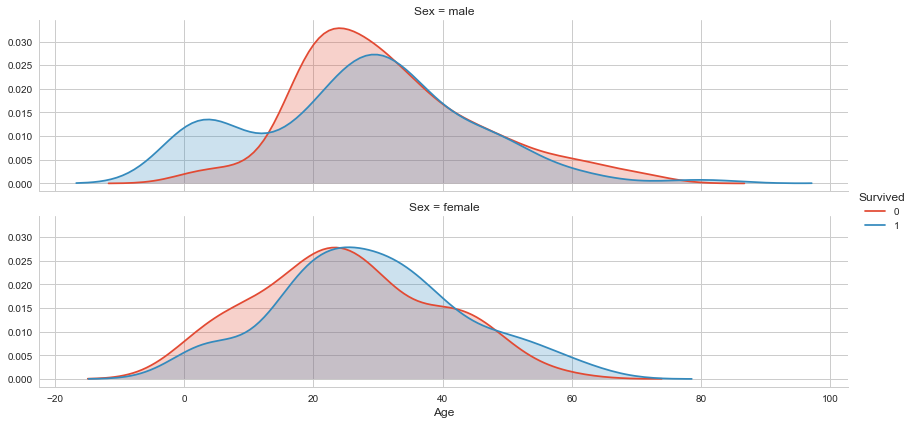

In [16]:
plot_distribution( train_raw , var = 'Age' , target = 'Survived' , row = 'Sex' )

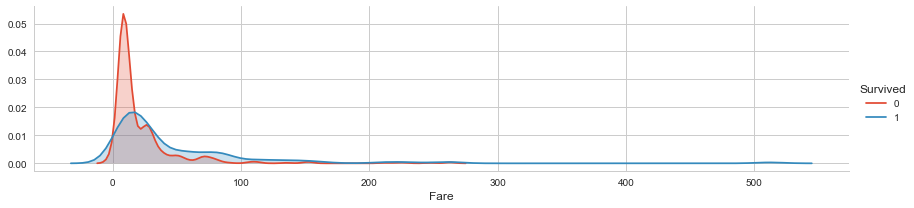

In [17]:
plot_distribution( train_raw , var = 'Fare' , target = 'Survived')

# Feature engineering

In this section, missing values will be filled with estimated values, dummy variables will be created and a new 'title' feature will be created

In [18]:
train_test.head()

,age,cabin,embarked,fare,name,parch,passengerid,pclass,sex,sibsp,survived,ticket,train_test
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,train
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,train
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,train
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,train
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,train


In [19]:
# check missing values in features
train_test.isnull().sum()

age             263
cabin          1014
embarked          2
fare              1
name              0
parch             0
passengerid       0
pclass            0
sex               0
sibsp             0
survived        418
ticket            0
train_test        0
dtype: int64

### Title

In [20]:
# Reference: https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
def process_title(full_name):
    # a map of more aggregated titles
    title_dictionary = {
                        "Capt":       "officer",
                        "Col":        "officer",
                        "Major":      "officer",
                        "Jonkheer":   "royalty",
                        "Don":        "royalty",
                        "Sir" :       "royalty",
                        "Dr":         "officer",
                        "Rev":        "officer",
                        "the Countess":"royalty",
                        "Dona":       "royalty",
                        "Mme":        "commoner",
                        "Mlle":       "commoner",
                        "Ms":         "commoner",
                        "Mr" :        "commoner",
                        "Mrs" :       "commoner",
                        "Miss" :      "commoner",
                        "Master" :    "commoner",
                        "Lady" :      "royalty"
                        }
    
    title = full_name.split(', ')[1].split('.')[0]
    return title_dictionary.get(title, 'na')

train_test['title'] = train_test['name'].apply(process_title)

### Age

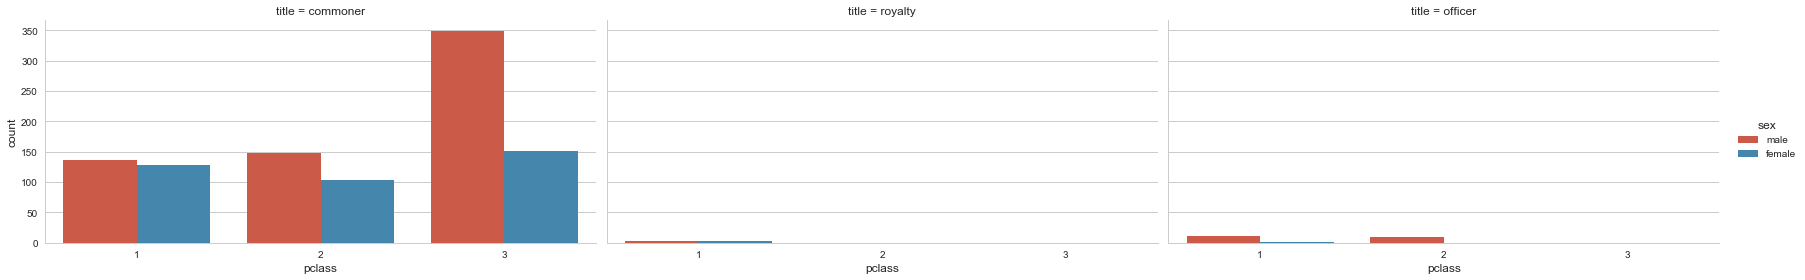

In [21]:
# check the distribution of non-na age people and see if there are sufficient samples to fill na with median
_ = sns.factorplot(x='pclass', hue='sex', col='title', data=train_test[~train_test.age.isnull()], 
                   kind='count', size=4, aspect=2)

In [22]:
train_test.age = train_test.groupby(by=['sex', 'pclass', 'title', 'train_test'])['age']\
                    .apply(lambda x: x.fillna(x.median()))

### Embarked

In [23]:
train_test.embarked = train_test\
                        .groupby(by=['train_test'])['embarked']\
                        .transform(lambda x: x.fillna(x.mode().loc[0]))

### Fare

In [24]:
train_test.fare = train_test\
                    .groupby(by=['pclass', 'embarked', 'sex', 'title', 'train_test'])['fare']\
                    .transform(lambda x: x.fillna(x.mean()))

### Cabin

In [25]:
train_test.cabin.fillna(value='U', inplace=True)

# Pick the first character of the cabin code
train_test.cabin = train_test.cabin.str[0]

### Ticket

In [26]:
train_test.ticket = train_test.ticket.str.replace('\d+', '')\
                                     .str.replace(' ', '')\
                                     .str.replace('/', ' ')\
                                     .str.replace('.', '')\
                                     .str.strip()\
                                     .str.split(pat=' ').str[0]\
                                     .apply(lambda x: 'na' if len(x) < 1 else x)\
                                     .str.upper()

### Sex

In [27]:
# Cannot transform sex into {'male':1,'female':0} since it is a nominal feature which does not imply any order
# train_test.sex = train_test.sex.map({'male':1,'female':0})

### Family size

In [28]:
# introducing a new feature : the size of families (including the passenger)
train_test[ 'family_size' ] = train_test[ 'parch' ] + train_test[ 'sibsp' ] + 1

# introducing other features based on the family size
train_test[ 'family_single' ] = train_test[ 'family_size' ].map( lambda s : 1 if s == 1 else 0 )
train_test[ 'family_small' ]  = train_test[ 'family_size' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
train_test[ 'family_large' ]  = train_test[ 'family_size' ].map( lambda s : 1 if s >= 5 else 0 )

### Get dummy variables

In [29]:
dummy_var = ['sex', 'cabin', 'embarked', 'pclass', 'ticket', 'title']

for var in dummy_var:
    df_dummies = pd.get_dummies(data=train_test[var], prefix=var)
    train_test = pd.concat([train_test, df_dummies], axis=1)

### Drop unused variables

In [30]:
drop_var = ['name', 'passengerid', 'parch', 'sibsp', 'family_size'] + dummy_var
train_test.drop(labels=drop_var, axis=1, inplace=True)

### After data preparation

In [41]:
# check all na has been filled
train_test.isnull().sum()

age                 0
fare                0
survived          418
train_test          0
family_single       0
family_small        0
family_large        0
sex_female          0
sex_male            0
cabin_A             0
cabin_B             0
cabin_C             0
cabin_D             0
cabin_E             0
cabin_F             0
cabin_G             0
cabin_T             0
cabin_U             0
embarked_C          0
embarked_Q          0
embarked_S          0
pclass_1            0
pclass_2            0
pclass_3            0
ticket_A            0
ticket_AQ           0
ticket_C            0
ticket_CA           0
ticket_FA           0
ticket_FC           0
ticket_FCC          0
ticket_LINE         0
ticket_LP           0
ticket_NA           0
ticket_P            0
ticket_PC           0
ticket_PP           0
ticket_SC           0
ticket_SCO          0
ticket_SO           0
ticket_SOC          0
ticket_SOP          0
ticket_SOTON        0
ticket_SP           0
ticket_STON         0
ticket_SW 

In [42]:
# train set
X_train = train_test[train_test.train_test == 'train'].copy().reset_index(drop=True)
y_train = X_train.survived.copy()
X_train.drop(['train_test', 'survived'], axis=1, inplace=True)

# test set
X_test = train_test[train_test.train_test == 'test'].copy().reset_index(drop=True)
X_test.drop(['train_test', 'survived'], axis=1, inplace=True)

print (train_test.shape , X_train.shape , y_train.shape , X_test.shape)

(1309, 52) (891, 50) (891,) (418, 50)


# Modelling

### Comparing model performances

Getting some ideas what performances look like for different popular models in scikit-learn

(!) Improvement to this section: use nested cross-validation for algorithm selection

In [44]:
models = [RandomForestClassifier(n_estimators=50, n_jobs=-1),
          Pipeline([('scl', StandardScaler()), ('clf', SVC())]),
          GradientBoostingClassifier(),
          Pipeline([('scl', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors = 5, n_jobs=-1))]),
          GaussianNB(),
          Pipeline([('scl', StandardScaler()), ('clf', LogisticRegression(penalty='l2', n_jobs=-1))]),
          LinearSVC(),
          SGDClassifier()]

In [45]:
def compare_mode_perf(models, X, y):
    model_score_mean, model_score_std = list(), list()

    for model in models:
        model.fit(X, y)
        # Stratified k-fold cross-validation
        scores = cross_val_score(estimator=model,
                                 X=X,
                                 y=y,
                                 cv = LeaveOneOut(),  # LeaveOneOut is used for small dataset
                                 n_jobs=-1)
        model_score_mean.append(np.mean(scores))
        model_score_std.append(np.std(scores))

    model_names = list(map(lambda x: x.__class__.__name__ if x.__class__.__name__ != 'Pipeline' else 
                           x.steps[1][1].__class__.__name__, models))
    model_perf = pd.DataFrame({'model': model_names, 
                               'mean': model_score_mean, 
                               'std': model_score_std})\
                               [['model', 'mean', 'std']].sort_values('mean', ascending=False)
    return model_perf

compare_mode_perf(models, X_train, y_train)

,model,mean,std
2,GradientBoostingClassifier,0.830527,0.375169
1,SVC,0.814815,0.388448
5,LogisticRegression,0.814815,0.388448
0,RandomForestClassifier,0.812570,0.390256
3,KNeighborsClassifier,0.772166,0.419435
6,LinearSVC,0.764310,0.424429
7,SGDClassifier,0.644220,0.478749
4,GaussianNB,0.439955,0.496382


## Model 1: Random Forest

Trying Random Forest model as it is a popular and easy model

In [48]:
rfc = RandomForestClassifier(n_estimators=40, max_features='sqrt', n_jobs=-1, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

### Learning Curve - diagnose bias and variance problems (accuracy vs sample size)

In [49]:
train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=rfc,
                                                                          X=X_train,
                                                                          y=y_train,
                                                                          train_sizes=np.linspace(0.1, 1.0, 10),
                                                                          cv=40,
                                                                          scoring='roc_auc',
                                                                          n_jobs=-1
                                                                         )

In [51]:
def plot_learn_valid_curves(sizes, train_scores, test_scores, xlabel, ylabel, xscale=None):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
    plt.fill_between(sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

    plt.grid()
    if xscale is not None: plt.xscale(xscale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='lower right')
    plt.show()

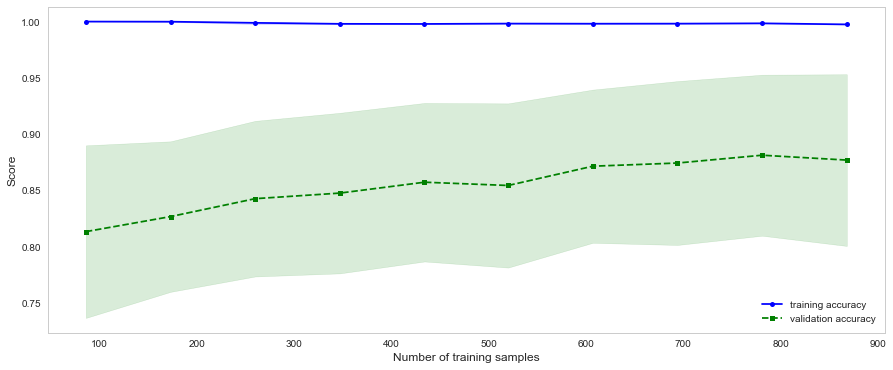

In [52]:
plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

Learning curve shows the model suffers from high variance (overfitting), indicated by the large gap between the training and cross-validation accuracy. 

Possible solutions:
- Collect more data
- Reduce model complexity
- Decrease number of features via feature selection or feature extraction

However those might not help if the training data are extremely noise or the model is very close to optimal.

### Validation curve - address overfitting and underfitting (accuracy vs complexity)

In [53]:
param_range = np.arange(1, 150, 5)
train_scores_valid, test_scores_valid = validation_curve(estimator=rfc,
                                                         X=X_train,
                                                         y=y_train,
                                                         param_name='n_estimators',
                                                         param_range=param_range,
                                                         cv=40,
                                                         scoring='roc_auc',
                                                         n_jobs=-1
                                                        )

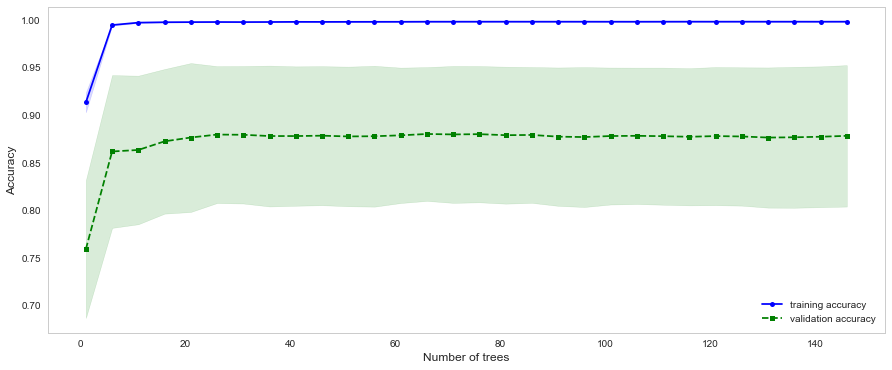

In [54]:
plot_learn_valid_curves(param_range, train_scores_valid, test_scores_valid, 'Number of trees', 'Accuracy')

Validation curve shows that the validation accuracy converges with ~25 trees

### Feature selection

#### Assessing feature importance with random forests

In [160]:
def plot_feature_imp(clf, X_train, top_feat=10):
    # Dataframe of feature importance
    imp = {'importance': clf.feature_importances_, 
           'sd': np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)}

    df_imp = pd.DataFrame(data=imp, 
                          index=X_train.columns)\
               .sort_values(by=['importance'], ascending=True)
    df_imp.index.name = 'feature'

    # Plot importances with error bars
    df_plot = df_imp.tail(top_feat)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.gca()
    ax.barh(df_plot.reset_index().index, 
            df_plot.importance, 
            color='0.8', 
            xerr=df_plot.sd
            )
    ax.set_yticks(df_plot.reset_index().index)  # where yticks are located
    ax.set_yticklabels(df_plot.index, fontsize=15)  # what the yticklabels are
    ax.yaxis.grid(False)
    sns.despine()

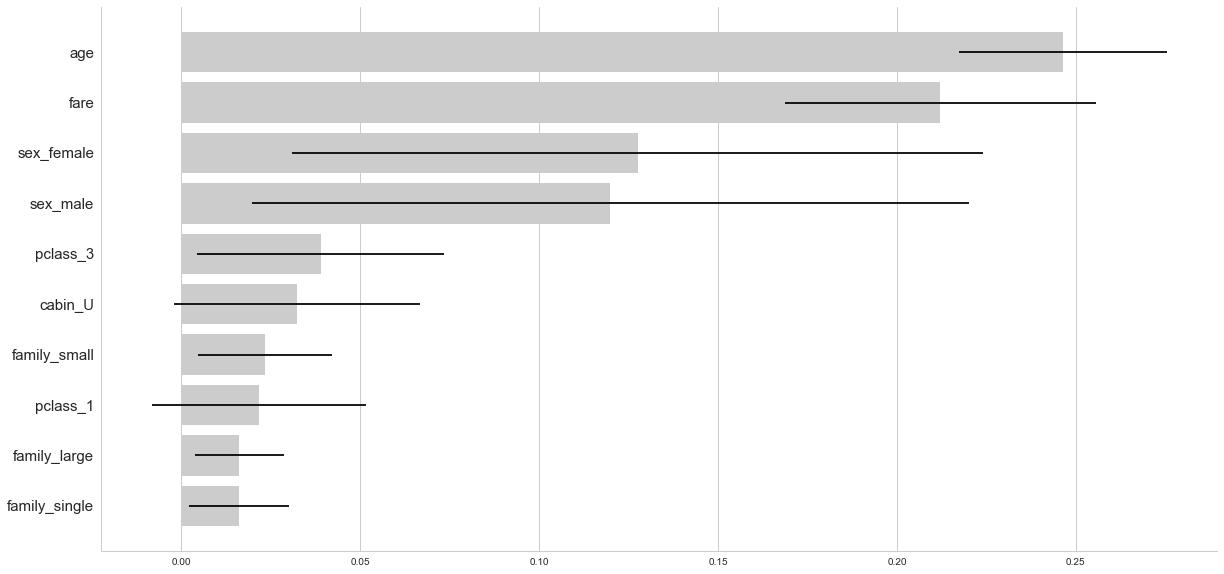

In [161]:
plot_feature_imp(rfc, X_train)

#### Choose the most important features & use 25 trees

In [163]:
pipe_rf = Pipeline([('rfs', SelectFromModel(rfc, threshold='median')), 
                    ('rfc', RandomForestClassifier(n_estimators=25, max_features='sqrt', n_jobs=-1, random_state=3326))])

#### Check learning curve if there is any improvement

In [ ]:
train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=pipe_rf,
                                                                          X=X_train,
                                                                          y=y_train,
                                                                          train_sizes=np.linspace(0.1, 1.0, 10),
                                                                          cv=40,
                                                                          scoring='roc_auc',
                                                                          n_jobs=-1
                                                                         )


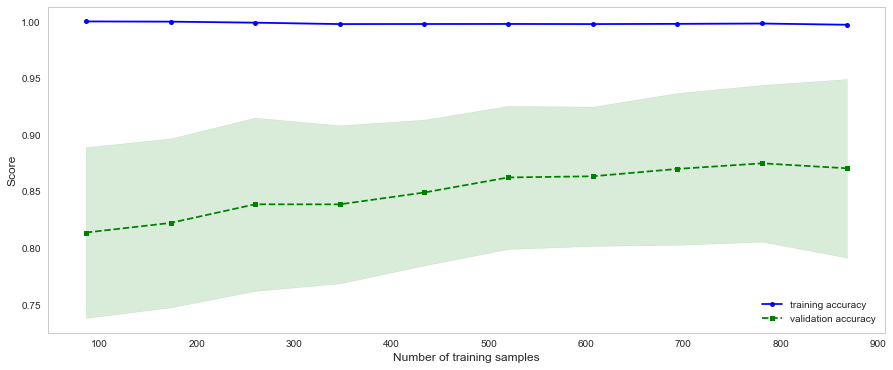

In [258]:
plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

Not much improvement.

### Tuning hyperparameters via grid search

Random search is used here as it takes significantly less time than full grid search and the outcomes usually have very similiar score to that of the full grid search.

In [55]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#### Random search

In [167]:
param_dist = {"rfc__max_depth": [3, None],
              "rfc__max_features": sp_randint(1, 11),
              "rfc__min_samples_split": sp_randint(2, 11),
              "rfc__min_samples_leaf": sp_randint(1, 11),
              "rfc__bootstrap": [True, False],
              "rfc__criterion": ["gini", "entropy"]}

n_iter_search = 50
random_search = RandomizedSearchCV(estimator=pipe_rf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=40)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 399.71 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.883 (std: 0.083)
Parameters: {'rfc__bootstrap': False, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__max_features': 10, 'rfc__min_samples_leaf': 6, 'rfc__min_samples_split': 5}

Model with rank: 2
Mean validation score: 0.883 (std: 0.087)
Parameters: {'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__max_features': 9, 'rfc__min_samples_leaf': 5, 'rfc__min_samples_split': 9}

Model with rank: 3
Mean validation score: 0.883 (std: 0.088)
Parameters: {'rfc__bootstrap': False, 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__max_features': 7, 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 10}



### ROC (with the best hyperparameters from grid search)
#### Visualising ROC of each CV fold

In [63]:
def calculate_roc(clf, cv, X, y):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    fold_roc = []

    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        probas = clf.fit(X=X.loc[train_index], y=y.loc[train_index]).predict_proba(X.loc[test_index])
        # probas return array([[p(0), p(1)], ...]). The order of the classes corresponds to gs.best_estimator_.classes_
        # Here probas[:, 1] picks all the probabolities for class 1 (also specified the pos_label=1)
        fpr, tpr, thresholds = roc_curve(y_true=y[test_index], y_score=probas[:, 1], pos_label=1)
        # To find the mean of the folds
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        fold_roc.append((fpr, tpr, roc_auc))

    mean_tpr /= cv.n_splits
    mean_tpr[-1] = 1.0 # to make sure it is exactly 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    return dict(fold_roc=fold_roc, mean_roc=(mean_fpr, mean_tpr, mean_auc))


def plot_cv_roc(fold_roc, mean_roc):
    """ 
    roc : list
        List of tuples (fpr, tpr, auc)
    """
    plt.figure()
    for i, item in enumerate(fold_roc):
        plt.plot(item[0], item[1], lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, item[2]))
        
    plt.plot(mean_roc[0], mean_roc[1], 'k--', lw=2, label='mean ROC (area = %0.2f)' % mean_roc[2])
        
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')
    plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
    plt.xlabel('False positve rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operator Characteristics')
    plt.legend(loc='lower right')
    plt.show()

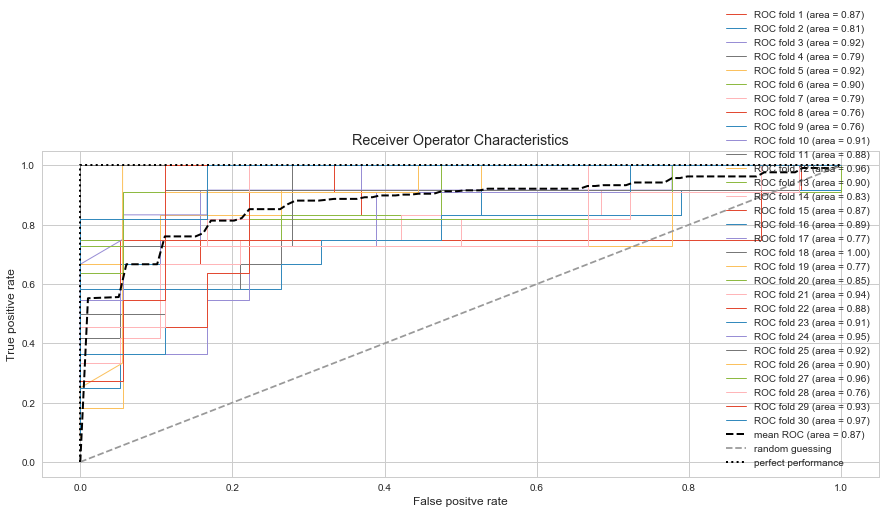

In [349]:
cv_roc = calculate_roc(gs.best_estimator_, StratifiedKFold(n_splits=30), X_train, y_train)
plot_cv_roc(cv_roc['fold_roc'], cv_roc['mean_roc'])

## Prediction and 1st deployment

In [125]:
print('Best score: {}'.format(gs.best_score_))
print('Best parameters: {}'.format(gs.best_params_))

# Select the best model
clf = gs.best_estimator_
clf.fit(X_train, y_train)
y_test = clf.predict(X_test)

Best score: 0.8880209296875965
Best parameters: {'rfc__bootstrap': True, 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 4}
(418, 2)


In [74]:
def deploy(y_pred, file_name):
    passenger_id = test_raw.PassengerId
    prediction = pd.DataFrame(data={'PassengerId': passenger_id , 'Survived': y_pred}, 
                              dtype=np.int)
    print (prediction.shape)
    prediction.head()
    prediction.to_csv(file_name, index = False )

In [ ]:
deploy(y_test, 'titanic_pred1.csv')

# Improvement 1
# Model 2: Majority Voting

In [293]:
seed = 0

In [320]:
clf1 = Pipeline([('scl', StandardScaler()),
                 ('clf', LogisticRegression(penalty='l2', n_jobs=-1, random_state=seed))])
clf2 = gs.best_estimator_
clf3 = GradientBoostingClassifier(random_state=seed, n_estimators=80)
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gbc', clf3)], voting='soft', n_jobs= -1)

In [322]:
clf_labels = ['Logistic Regression', 'Random Forest', 'Gradient Boost', 'Ensemble']
classifiers = [clf1, clf2, clf3, eclf]
for clf, label in zip(classifiers, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=40, scoring='accuracy')
    print("Accuracy: %0.3f (+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.820 (+/- 0.071) [Logistic Regression]
Accuracy: 0.819 (+/- 0.074) [Random Forest]
Accuracy: 0.831 (+/- 0.071) [Gradient Boost]
Accuracy: 0.830 (+/- 0.068) [Ensemble]


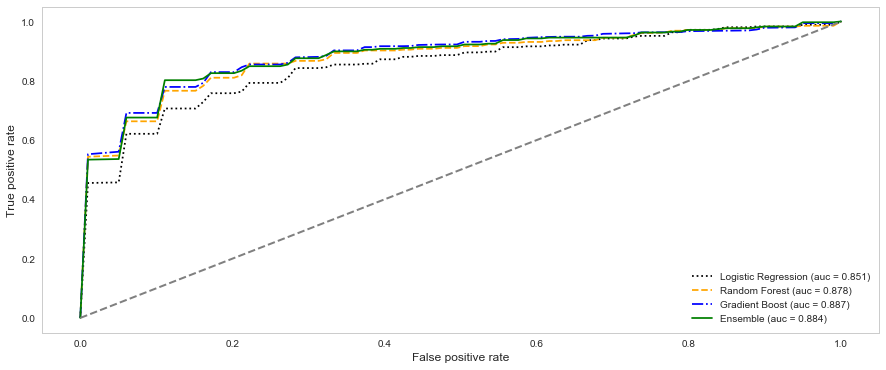

In [353]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(classifiers, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    clf_roc = calculate_roc(clf, StratifiedKFold(n_splits=30), X_train, y_train)['mean_roc']
    plt.plot(clf_roc[0], clf_roc[1], color=clr, linestyle=ls, label='{0} (auc = {1:0.3f})'.format(label, clf_roc[2]))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=2, label='Random guessing')
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

From the accuracy scores, all four classifiers have similar scores. However looking at the ROC curves, logistic regression has a lower AUC while the other three classifiers have similar performance.

## Random search

In [359]:
# see the parameteres to access
eclf.get_params()

{'estimators': [('lr',
   Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
             penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
             verbose=0, warm_start=False))])),
  ('rf',
   Pipeline(steps=[('rfs', SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='sqrt', max_leaf_nodes=None,
               min_impurity_split=1e-07, min_samples_leaf=1,
               min_samples_split=2, min_weight_fraction_le...mators=35, n_jobs=-1, oob_score=False, random_state=None,
               verbose=0, warm_start=False))])),
  ('gbc', GradientBoostingClassifier(criterion='friedman_mse', init=None,
                 learning_rate=0.1, loss='deviance', max_depth=3,
                 max_featu

In [ ]:
eparam_range = [0.001, 0.01, 0.1, 1, 10, 100]
eparam_dist = {'lr__clf__penalty': ['l1', 'l2'],
               'lr__clf__C': eparam_range,
               'gbc__n_estimators': sp_randint(15, 100),
               'gbc__min_samples_split': sp_randint(2, 11),
               'gbc__min_samples_leaf': sp_randint(1, 11),
               'gbc__max_features': sp_randint(1, 11)
               }
n_iter_search = 50
random_search = RandomizedSearchCV(estimator=eclf, 
                                   param_distributions=eparam_dist,
                                   n_iter=n_iter_search,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   cv=30)

start = time()
print (start)
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train_sizes_learn, train_scores_learn, test_scores_learn = learning_curve(estimator=random_search.best_estimator_,
                                                                              X=X_train,
                                                                              y=y_train,
                                                                              train_sizes=np.linspace(0.1, 1.0, 10),
                                                                              cv=40,
                                                                              scoring='roc_auc',
                                                                              n_jobs=-1
                                                                             )



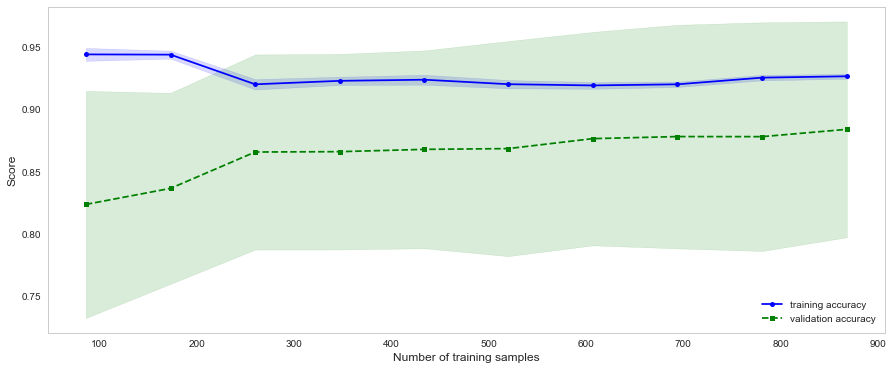

In [373]:
plot_learn_valid_curves(train_sizes_learn, train_scores_learn, test_scores_learn, 
                        'Number of training samples', 'Score')

From the above learning curve, ensemble method has provided a better bias-variance trade-off.

In [376]:
np.mean(test_scores_learn[-1])

0.88392284798534804

In [370]:
y_test = random_search.best_estimator_.fit(X_train, y_train).predict(X_test)
deploy(y_test, 'titanic_pred2.csv')

(418, 2)


#### Submission result: majority voting is an improvement to a sole random forest classifier.

# Improvement ideas

- Bagging
- XG Boost
- https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

# Appendix

## 1. Check feature weights of logistic regression

In [46]:
pipe_lr = Pipeline([('scl', StandardScaler()), 
                    ('clf', LogisticRegression(penalty='l2', n_jobs=-1))])
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [47]:
log_reg_weight = pd.DataFrame({'feature': X_train.columns.tolist(), 'weight': pipe_lr.steps[1][1].coef_[0]})\
                    .sort_values(by='weight', ascending=False)
print (log_reg_weight.head())
print ('----------')
print (log_reg_weight.tail())

        feature    weight
5    sex_female  0.659140
19     pclass_1  0.367369
43    ticket_SW  0.347671
11      cabin_E  0.302000
42  ticket_STON  0.237941
----------
         feature    weight
38    ticket_SOC -0.322108
21      pclass_3 -0.423773
4   family_large -0.490849
0            age -0.594322
6       sex_male -0.659140


The weights suggest that (and make sense):
- Females were more likely to survive
- Family_large, male and young age were less likely to survive

## 2. Full grid search

In [114]:
param_grid = {'rfc__max_depth' : [3, None],
              'rfc__max_features': ['sqrt', 'log2'],
              'rfc__min_samples_split': [2, 4, 6, 8],
              'rfc__min_samples_leaf': [1, 2, 3, 4],
              'rfc__bootstrap': [True, False],
              'rfc__criterion': ["gini", "entropy"]
              }

gs = GridSearchCV(estimator=pipe_rf,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  cv=40,
                  n_jobs=-1)

start = time()
gs = gs.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(gs.cv_results_['params'])))
report(gs.cv_results_)

GridSearchCV took 2834.05 seconds for 256 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.888 (std: 0.081)
Parameters: {'rfc__bootstrap': True, 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 4, 'rfc__min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.887 (std: 0.081)
Parameters: {'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_depth': None, 'rfc__max_features': 'sqrt', 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 8}

Model with rank: 3
Mean validation score: 0.887 (std: 0.072)
Parameters: {'rfc__bootstrap': True, 'rfc__criterion': 'entropy', 'rfc__max_depth': None, 'rfc__max_features': 'log2', 'rfc__min_samples_leaf': 1, 'rfc__min_samples_split': 8}

